<a href="https://colab.research.google.com/github/poncho-ajmv/Proyecto6toSemestre/blob/main/RepoExamen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importacion de librerias

In [147]:
# 1. Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

#2. Lectura de datasets


In [148]:
# 2. Lectura de datasets
datos_entrenamiento = pd.read_csv('dataset_telefonos.csv')
datos_prueba = pd.read_csv('dataset_telefonos_compania.csv')


#3. Exploracion de los datos

In [149]:
# 3. Exploración de los datos
datos_entrenamiento.describe()

,screen_height,screen_width,weight_meassure,clock_speed,memory_capacity,ram_capacity
count,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000
mean,12.319487,5.782564,140.209744,1.522667,32.046667,2120.684103
std,4.216070,4.349520,35.372294,0.813918,18.162777,1086.869412
min,5.000000,0.000000,80.000000,0.500000,2.000000,256.000000
25%,9.000000,2.000000,109.000000,0.700000,16.000000,1205.000000
50%,12.000000,5.000000,141.000000,1.500000,32.000000,2130.500000
75%,16.000000,9.000000,170.000000,2.200000,48.000000,3067.500000
max,19.000000,18.000000,200.000000,3.000000,64.000000,3998.000000


In [150]:
datos_entrenamiento.head()

,screen_height,screen_width,weight_meassure,clock_speed,cores,memory_capacity,ram_capacity,dual_sim,bluetooth,wifi,price_range
0,17,12,103,0.5,Dual-Core,64,3786,False,False,False,Alta Gama
1,16,12,145,2.3,Dual-Core,52,2501,False,True,False,Alta Gama
2,9,4,161,0.9,Dual-Core,58,1850,True,True,False,Media
3,12,7,126,2.7,Quad-Core,5,3035,True,True,True,Alta
4,7,5,114,1.3,Octa-Core,10,2203,True,True,True,Media


In [151]:
print("Valores únicos en 'cores':", datos_entrenamiento['cores'].unique())
print("Valores únicos en 'price_range':", datos_entrenamiento['price_range'].unique())

Valores únicos en 'cores': ['Dual-Core' 'Quad-Core' 'Octa-Core' 'Hepta-Core' 'Triple-Core'
 'Hexa-Core' 'Penta-Core' 'Single-Core']
Valores únicos en 'price_range': ['Alta Gama' 'Media' 'Alta' 'Baja']


#4. Defincicion de funciones de transformacion

In [152]:
# 4. Definición de funciones de transformación

def bool_a_entero(valor):
    return 1 if valor else 0

def mapear_cores(cadena):
    mapeo = {
        'Dual-Core': 2,
        'Quad-Core': 4,
        'Octa-Core': 8,
        'Hepta-Core': 7,
        'Triple-Core': 3,
        'Hexa-Core': 6,
        'Penta-Core': 5,
        'Single-Core': 1
    }
    return mapeo.get(cadena, 0)

def normalizar_min_max(columna):
    minimo = columna.min()
    maximo = columna.max()
    if minimo == maximo:
        return columna - minimo
    else:
        return (columna - minimo) / (maximo - minimo)

#5. Prepocesamiento de datos

In [153]:
# Factorizamos 'price_range' en datos de entrenamiento y obtenemos las clases
datos_entrenamiento['price_range'], clases = pd.factorize(datos_entrenamiento['price_range'])
print("Clases en entrenamiento:", clases)

# Usamos pd.Categorical para asignar los mismos códigos a los datos de prueba
datos_prueba['price_range'] = pd.Categorical(datos_prueba['price_range'], categories=clases).codes

# Lista de columnas a transformar
columnas = ['screen_height', 'screen_width', 'weight_meassure', 'clock_speed',
            'cores', 'memory_capacity', 'ram_capacity', 'dual_sim', 'bluetooth',
            'wifi', 'price_range']

for col in columnas:
    if col == 'cores':
        datos_entrenamiento[col] = datos_entrenamiento[col].apply(mapear_cores)
        datos_prueba[col] = datos_prueba[col].apply(mapear_cores)
    elif col == 'price_range':
        continue  # Ya se procesó
    elif col in ['dual_sim', 'bluetooth', 'wifi']:
        datos_entrenamiento[col] = datos_entrenamiento[col].apply(bool_a_entero)
        datos_prueba[col] = datos_prueba[col].apply(bool_a_entero)
    else:
        datos_entrenamiento[col] = normalizar_min_max(datos_entrenamiento[col])
        datos_prueba[col] = normalizar_min_max(datos_prueba[col])

print(datos_entrenamiento.describe())
print(datos_prueba.describe())

Clases en entrenamiento: Index(['Alta Gama', 'Media', 'Alta', 'Baja'], dtype='object')
       screen_height  screen_width  weight_meassure  clock_speed        cores  \
count    1950.000000   1950.000000      1950.000000  1950.000000  1950.000000   
mean        0.522821      0.321254         0.501748     0.409067     4.529744   
std         0.301148      0.241640         0.294769     0.325567     2.290563   
min         0.000000      0.000000         0.000000     0.000000     1.000000   
25%         0.285714      0.111111         0.241667     0.080000     3.000000   
50%         0.500000      0.277778         0.508333     0.400000     4.000000   
75%         0.785714      0.500000         0.750000     0.680000     7.000000   
max         1.000000      1.000000         1.000000     1.000000     8.000000   

       memory_capacity  ram_capacity     dual_sim    bluetooth         wifi  \
count      1950.000000   1950.000000  1950.000000  1950.000000  1950.000000   
mean          0.484624   

#6. Preparacion de datos para el modelo

In [154]:
# 6. Preparación de datos para el modelo
variables = datos_entrenamiento.drop('price_range', axis=1)
objetivo = datos_entrenamiento['price_range']

#7. Entrenamiento del modelo

In [155]:
# 7. Definición, compilación y entrenamiento del modelo (modelo mejorado)
# Se aumenta el número de neuronas y se agregan capas Dropout para evitar sobreajuste


modelo = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(len(variables.columns),)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 clases
])

modelo.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer='adam',
               metrics=['accuracy'])

# Se incrementa el número de épocas para permitir un mejor aprendizaje
historial = modelo.fit(variables,
                       objetivo,
                       epochs=50,
                       batch_size=128,
                       validation_split=0.2)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.2447 - loss: 1.4725 - val_accuracy: 0.2821 - val_loss: 1.3797
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2360 - loss: 1.4265 - val_accuracy: 0.3231 - val_loss: 1.3783
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2606 - loss: 1.3985 - val_accuracy: 0.3487 - val_loss: 1.3727
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2690 - loss: 1.3939 - val_accuracy: 0.3897 - val_loss: 1.3666
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2714 - loss: 1.3797 - val_accuracy: 0.4000 - val_loss: 1.3576
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3148 - loss: 1.3723 - val_accuracy: 0.4436 - val_loss: 1.3487
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3024 - loss: 1.3725 - val_accuracy: 0.4179 - val_loss: 1.3379
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3314 - loss: 1.3664 - val_accuracy: 0.4256 - val_loss: 1.3239
Ep

#8. Evaluacion y matriz de confusion

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


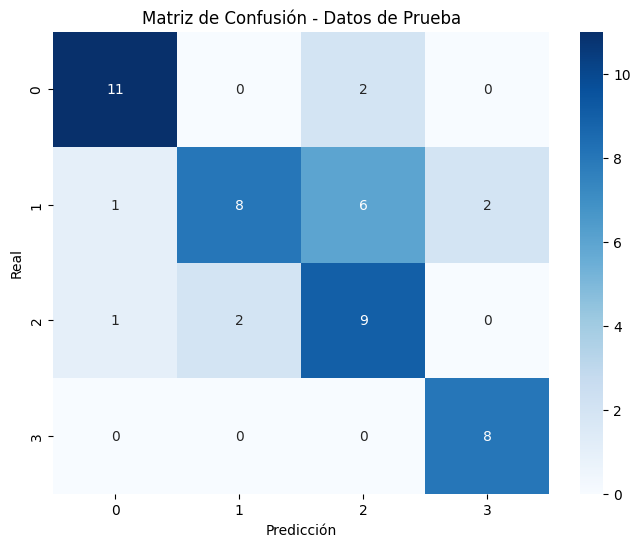

In [156]:
# 8. Evaluación y matriz de confusión en datos de prueba
X_prueba = datos_prueba.drop('price_range', axis=1)
y_prueba = datos_prueba['price_range']
predicciones = modelo.predict(X_prueba)
predichas = np.argmax(predicciones, axis=1)

# Se genera la matriz de confusión usando pd.crosstab
matriz_conf = pd.crosstab(y_prueba, pd.Series(predichas, name='Predicción'),
                          rownames=['Real'], colnames=['Predicción'])

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_conf, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Datos de Prueba")
plt.show()


#9. Evaluacion final de datos de **prueba**

In [157]:
# 9. Evaluación final en datos de prueba
perdida, exactitud = modelo.evaluate(X_prueba, y_prueba)
print(f"Pérdida: {perdida}")
print(f"Exactitud: {exactitud}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7196 - loss: 0.6767 
Pérdida: 0.6884893774986267
Exactitud: 0.7200000286102295
